# Resolução do Case

Neste notebook, apresentamos a solução do case proposto. Todos os pacotes necessários para a análise são carregados em seguida. Na análise abaixo, vamos usar a base do ano de 2017 para fazer as análises. Toda o código é facilmente adapatado para 
os outros anos, bastando carregar a base do ano desejado. 

Diversas informações sobre a base são analisadas, como está exposto abaixo.

## 1. Pacotes

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm

## 2. Carrega base

* Vamos carregar as bases que serão utilizadas na análise

In [2]:
# Carrega a base dos jogos

df_2017 = pd.read_csv("../data/2017.csv/2017.csv", sep=",", nrows=None)
print(df_2017.shape)
df_2017.head()

(7466025, 10)


,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2017-01-01 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992418.0,2028543.0
1,2017-01-01 00:00:00,A002,R051,02-00-01,59 ST,NQR456W,BMT,REGULAR,5475502.0,1204841.0
2,2017-01-01 00:00:00,A002,R051,02-03-00,59 ST,NQR456W,BMT,REGULAR,842188.0,3132405.0
3,2017-01-01 00:00:00,A002,R051,02-03-01,59 ST,NQR456W,BMT,REGULAR,123036.0,218034.0
4,2017-01-01 00:00:00,A002,R051,02-03-02,59 ST,NQR456W,BMT,REGULAR,5210075.0,7206414.0


In [3]:
# Mostra colunas

df_2017.columns

Index(['time', 'ca', 'unit', 'scp', 'station', 'linename', 'division', 'desc',
       'entries', 'exits'],
      dtype='object')

In [4]:
# Mostra os tipos de colunas

df_2017.dtypes

time         object
ca           object
unit         object
scp          object
station      object
linename     object
division     object
desc         object
entries     float64
exits       float64
dtype: object

In [5]:
# Converte para o formato datetime e muda o nome da coluna

df_2017['time'] = pd.to_datetime(df_2017['time'])

df_2017.rename(columns={'time': 'datetime'}, inplace=True)
df_2017.dtypes

datetime    datetime64[ns]
ca                  object
unit                object
scp                 object
station             object
linename            object
division            object
desc                object
entries            float64
exits              float64
dtype: object

Cada catraca é definida pela combinação única da área de controle, unidade remota, a posição do canal da subunidade e o nome da estação

In [6]:
df_2017['turnstile'] = df_2017['ca'] + '-' + df_2017['unit'] + '-' + df_2017['scp'] + '-' + df_2017['station']

### 2.1 Original data

Primeiro, procuramos valores de entradas e saídas anormais em potencial. Como as entradas e saídas são valores cumulativos, os quartis não significam nada, mas não deve haver valores negativos. Esperamos que as entradas sejam maiores do que as saídas em geral, porque as estações de metrô de Nova York geralmente têm saídas de emergência, que não coletam registros de saída. As saídas só são coletadas quando um passageiro sai por uma catraca.

In [7]:
print('Descriptions of entries:')
print(df_2017['entries'].describe())
print('')
print('Descriptions of exits:')
print(df_2017['exits'].describe())

Descriptions of entries:
count    7.466025e+06
mean     3.776361e+07
std      2.024034e+08
min      0.000000e+00
25%      5.066570e+05
50%      2.650150e+06
75%      6.773230e+06
max      2.130669e+09
Name: entries, dtype: float64

Descriptions of exits:
count    7.466025e+06
mean     3.013008e+07
std      1.821529e+08
min      0.000000e+00
25%      2.492370e+05
50%      1.491158e+06
75%      4.758698e+06
max      2.097116e+09
Name: exits, dtype: float64


### 2.2 Use differenced data

Em seguida, calculamos as diferenças entre cada dois timestamps de coleta e procuramos entradas/saídas anormais por intervalo de tempo. Os valores NaN são gerados para o primeiro registro de dados para cada catraca exclusiva durante a diferenciação.

In [48]:
df_2017_sorted = df_2017.sort_values(['turnstile', 'datetime'])
df_2017_sorted = df_2017_sorted.reset_index(drop = True)
print(df_2017_sorted.shape)
df_2017_sorted.head()

(7466025, 11)


,datetime,ca,unit,scp,station,linename,division,desc,entries,exits,turnstile
0,2017-01-01 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992418.0,2028543.0,A002-R051-02-00-00-59 ST
1,2017-01-01 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992638.0,2028572.0,A002-R051-02-00-00-59 ST
2,2017-01-01 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992718.0,2028585.0,A002-R051-02-00-00-59 ST
3,2017-01-01 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992730.0,2028594.0,A002-R051-02-00-00-59 ST
4,2017-01-01 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992776.0,2028636.0,A002-R051-02-00-00-59 ST


In [49]:
# Agrupa a base para cada catraca

turnstile_grouped = df_2017_sorted.groupby(['turnstile'])

# Calcula as diferenças entre dois entradas/saidas consecutivas:

df_2017_sorted['entries_diff'] = turnstile_grouped['entries'].transform(pd.Series.diff)
df_2017_sorted['exits_diff'] = turnstile_grouped['exits'].transform(pd.Series.diff)

df_2017_sorted.head()

,datetime,ca,unit,scp,station,linename,division,desc,entries,exits,turnstile,entries_diff,exits_diff
0,2017-01-01 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992418.0,2028543.0,A002-R051-02-00-00-59 ST,NaN,NaN
1,2017-01-01 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992638.0,2028572.0,A002-R051-02-00-00-59 ST,220.0,29.0
2,2017-01-01 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992718.0,2028585.0,A002-R051-02-00-00-59 ST,80.0,13.0
3,2017-01-01 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992730.0,2028594.0,A002-R051-02-00-00-59 ST,12.0,9.0
4,2017-01-01 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992776.0,2028636.0,A002-R051-02-00-00-59 ST,46.0,42.0


In [50]:
# del df_2017

# Checa algumas informações estatísticas:

s1 = df_2017_sorted['entries_diff'].describe()
s2 = df_2017_sorted['exits_diff'].describe()

pd.concat([s1, s2], axis=1)

,entries_diff,exits_diff
count,7.461254e+06,7.461254e+06
mean,2.881134e+03,2.286621e+03
std,3.041635e+06,3.130316e+06
min,-2.078544e+09,-1.879048e+09
25%,9.000000e+00,8.000000e+00
50%,7.500000e+01,5.100000e+01
75%,2.410000e+02,1.620000e+02
max,2.122193e+09,2.088503e+09


O número de observações com NaN deve ser igual ao número de catracas únicas. entry_diff e exits_diff devem sempre ser positivos, pois os valores cumulativos devem aumentar ou pelo menos permanecer iguais.

In [51]:
print('Number of negative entries_diff: %d' %len(df_2017_sorted['entries_diff'][df_2017_sorted['entries_diff'] < 0]))
print('Number of negative exits_diff: %d' %len(df_2017_sorted['exits_diff'][df_2017_sorted['exits_diff'] < 0]))
print('Number of unqiue turnstiles: %d' %len(df_2017_sorted['turnstile'].unique()))
print('Number of NaN rows: %d' %len(df_2017_sorted[df_2017_sorted['entries_diff'].isnull()]))

Number of negative entries_diff: 47928
Number of negative exits_diff: 33625
Number of unqiue turnstiles: 4771
Number of NaN rows: 4771


Os valores máximos de entry_diff e exits_diff são mais de um milhão de vezes maiores que seus percentis 75, o que aparentemente é anormal. Os valores mínimos são negativos, o que também é anormal. Vamos definir esses valores atípicos como 0. Parece que as contagens de entrada e saída podem ser redefinidas ao experimentar o fechamento da porta. Seria inapropriado inferir os valores corretos para essas observações, portanto, vamos defini-los como 0. Também definimos os NAs como 0, pois são o primeiro registro de dados para cada catraca.

In [52]:
df_2017_sorted['entries_diff'] = df_2017_sorted['entries_diff'].fillna(0)
df_2017_sorted['exits_diff'] = df_2017_sorted['exits_diff'].fillna(0)

df_2017_sorted.loc[df_2017_sorted['entries_diff'] < 0, 'entries_diff'] = 0
df_2017_sorted.loc[df_2017_sorted['exits_diff'] < 0, 'exits_diff'] = 0

df_2017_sorted.loc[df_2017_sorted['entries_diff'] >= 6000, 'entries_diff'] = 0
df_2017_sorted.loc[df_2017_sorted['exits_diff'] >= 6000, 'exits_diff'] = 0

## 3. Quais são as estações e catracas mais movimentadas?

Definimos ocupação/tráfego total como a soma de entradas e saídas para cada intervalo de tempo (tráfego total = entradas + saídas)

In [57]:
# Mostra colunas

df_2017_sorted.columns

Index(['datetime', 'ca', 'unit', 'scp', 'station', 'linename', 'division',
       'desc', 'entries', 'exits', 'turnstile', 'entries_diff', 'exits_diff'],
      dtype='object')

In [84]:
# Seleciona algumas colunas

df_2017_h1 = df_2017_sorted[['turnstile','station', 'datetime','entries_diff','exits_diff']]

# Criando a coluna ocupação: 
df_2017_h1.loc[:, 'busy'] = df_2017_h1['entries_diff'].values + df_2017_h1['exits_diff'].values

# del [mta_sorted]
print(df_2017_h1.shape)
df_2017_h1.head()

(7466025, 6)


C:\Users\mille\AppData\Local\Temp\ipykernel_3460\1795196512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017_h1.loc[:, 'busy'] = df_2017_h1['entries_diff'].values + df_2017_h1['exits_diff'].values


,turnstile,station,datetime,entries_diff,exits_diff,busy
0,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 00:00:00,0.0,0.0,0.0
1,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 04:00:00,220.0,29.0,249.0
2,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 08:00:00,80.0,13.0,93.0
3,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 12:00:00,12.0,9.0,21.0
4,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 16:00:00,46.0,42.0,88.0


### 3.1 As 10 estações mais ocupadas

* As 10 estações mostradas no gráfico abaixo normalmente têm várias linhas de metrô

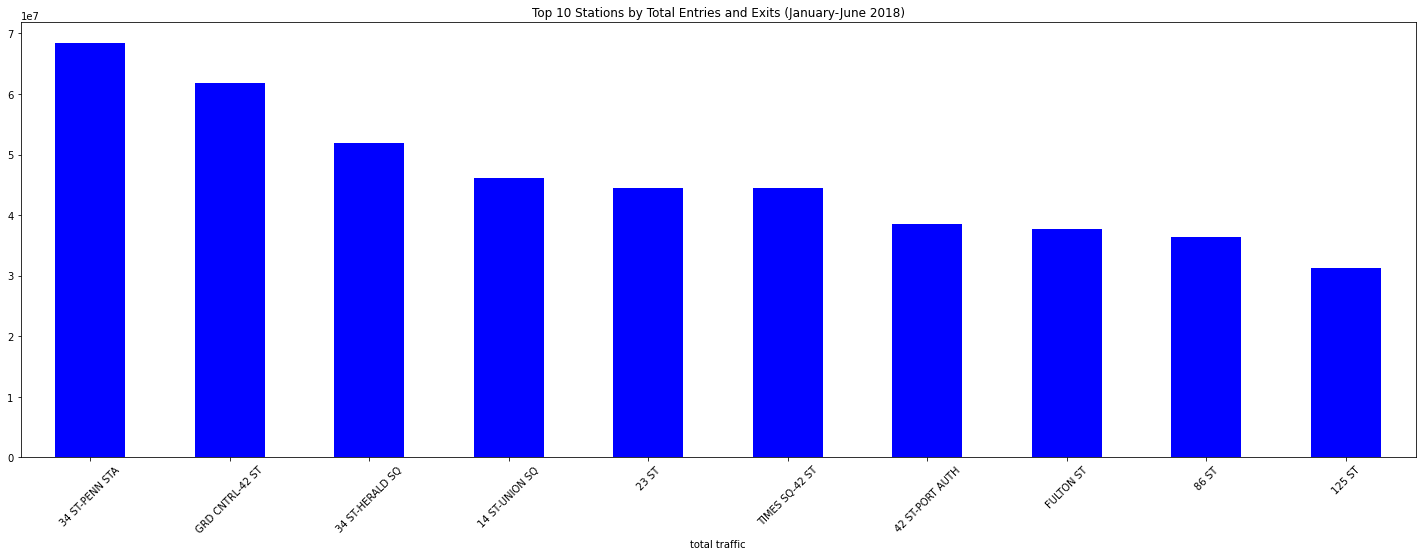

In [85]:
# Seleciona as 10 mais lotadas

top_10 =df_2017_h1.groupby(['station']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False).head(10)

# Plota as 10 estações mais lotadas

fig, ax = plt.subplots(figsize=(25, 8))
top_10.sort_values(by = 'busy',ascending=False).plot(kind='bar', color ='blue',ax=ax)
ax.set(title='Top 10 Stations by Total Entries and Exits (January-June 2018)', xlabel='total traffic', ylabel='')
plt.xticks(rotation=45)
ax.legend().set_visible(False)

* As estações 34 ST-PENN STA, GRD CNTRL-42 ST, 34 ST-HERALD SQ também são importantes estações de trem/ônibus que ligam Nova York a outras cidades/estados da costa leste. Por exemplo, um grande número de pessoas se desloca diariamente entre Nova York e Nova Jersey via Penn Station.

In [86]:
top_10.index

Index(['34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ',
       '14 ST-UNION SQ', '23 ST', 'TIMES SQ-42 ST', '42 ST-PORT AUTH',
       'FULTON ST', '86 ST', '125 ST'],
      dtype='object', name='station')

### 3.2 Catracas na estação mais movimentada

Calcular o tráfego por catraca para cada estação pode ajudar a MTA a projetar melhor as entradas do metrô, planejar a construção e localizar catracas com defeito. Se tivermos informações sobre a localização exata das saídas para cada catraca, poderemos descobrir melhor o fluxo de tráfego.

In [87]:
# Seleciona a catraca mais movimentada

mta_penn = df_2017_h1[df_2017_h1['station'] == '34 ST-PENN STA']
print('Number of turnstiles at 34-PENN STATION: %d' % len(mta_penn.turnstile.unique()))

Number of turnstiles at 34-PENN STATION: 98


Existem 98 catracas na 34 Penn Station, o tráfego em cada catraca varia enormemente, variando de menos de 100 contagens a mais de 13 milhões de contagens, como exposto abaixo

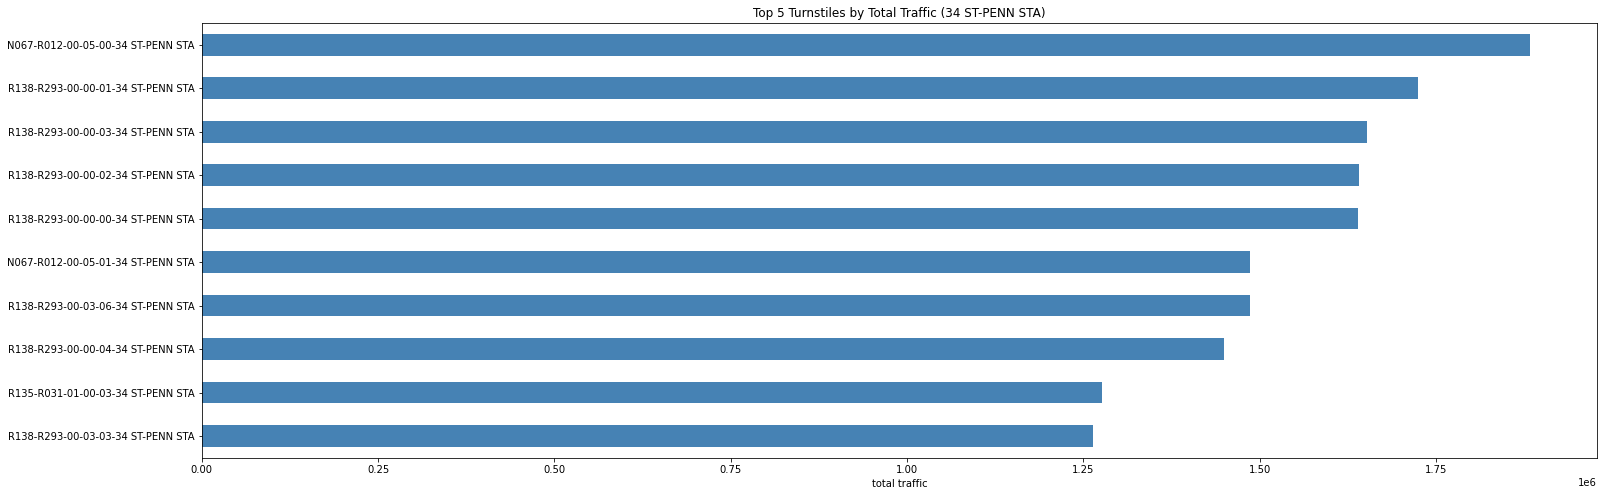

In [88]:
# Plota as 10 catracas com mais ocupação

top_10 =mta_penn.groupby(['turnstile']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False).head(10)

fig, ax = plt.subplots(figsize=(25, 8))
top_10.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='steelblue',ax=ax)
ax.set(title='Top 5 Turnstiles by Total Traffic (34 ST-PENN STA)', xlabel='total traffic', ylabel='')
ax.legend().set_visible(False)

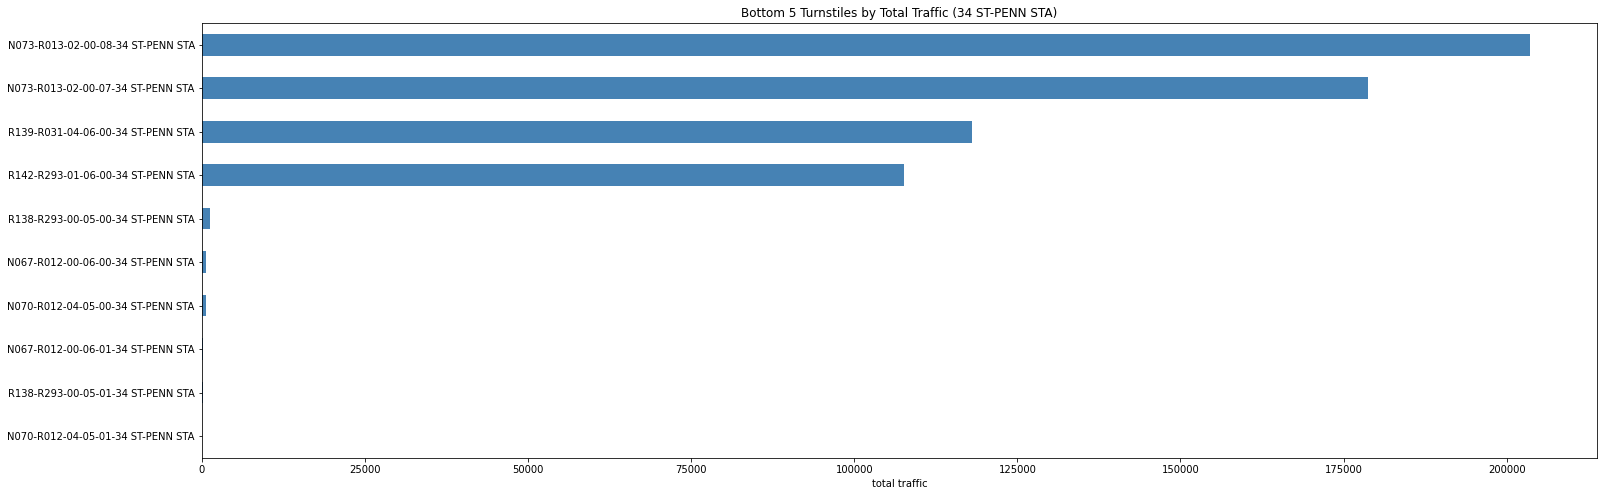

In [89]:
# Plota as 10 catracas com menos ocupação

bottom_10 =mta_penn.groupby(['turnstile']).agg({'busy': sum}).sort_values(by = 'busy', ascending = True).head(10)

fig, ax = plt.subplots(figsize=(25, 8))
bottom_10.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='steelblue',ax=ax)
ax.set(title='Bottom 5 Turnstiles by Total Traffic (34 ST-PENN STA)', xlabel='total traffic', ylabel='')
ax.legend().set_visible(False)

## 4. Qual é a hora mais movimentada para a estação mais movimentada - reamostragem dos dados da série temporal

In [90]:
# Seleciona a estação mais movimentada

mta_penn = df_2017_h1[(df_2017_h1['station'] == '34 ST-PENN STA')]
mta_penn.head()

,turnstile,station,datetime,entries_diff,exits_diff,busy
1901618,N067-R012-00-00-00-34 ST-PENN STA,34 ST-PENN STA,2017-01-01 00:00:00,0.0,0.0,0.0
1901619,N067-R012-00-00-00-34 ST-PENN STA,34 ST-PENN STA,2017-01-01 04:00:00,43.0,92.0,135.0
1901620,N067-R012-00-00-00-34 ST-PENN STA,34 ST-PENN STA,2017-01-01 08:00:00,4.0,31.0,35.0
1901621,N067-R012-00-00-00-34 ST-PENN STA,34 ST-PENN STA,2017-01-01 12:00:00,1.0,4.0,5.0
1901622,N067-R012-00-00-00-34 ST-PENN STA,34 ST-PENN STA,2017-01-01 16:00:00,14.0,35.0,49.0


In [91]:
# Obtendo a variável temporal.

mta_penn['time'] = mta_penn['datetime'].dt.time   
mta_penn['time'] = pd.to_datetime(mta_penn['time'], format = '%H:%M:%S')

# 

mta_penn_grouped = mta_penn.groupby(['time']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False)
#mta_penn_grouped.head()
#
mta_penn_grouped.resample('60T',convention='end').sum().sort_values(by = 'busy', ascending = False).head()


C:\Users\mille\AppData\Local\Temp\ipykernel_3460\2087392687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_penn['time'] = mta_penn['datetime'].dt.time
C:\Users\mille\AppData\Local\Temp\ipykernel_3460\2087392687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_penn['time'] = pd.to_datetime(mta_penn['time'], format = '%H:%M:%S')


,busy
time,
1900-01-01 00:00:00,15972211.0
1900-01-01 16:00:00,12079653.0
1900-01-01 20:00:00,9060142.0
1900-01-01 04:00:00,5674246.0
1900-01-01 22:00:00,5306233.0


Os registros de dados originais são normalmente gerados a cada 4 horas. Reamostramos os dados usando 1 hora como o novo intervalo de tempo. A hora mais movimentada da 34 ST-PENN STATION é às 00h.

## 5. Visualização do tráfégo

### 5.1 Tráfego total diário para todas as estações em Nova York
No gráfico abaixo, traçamos o tráfego total diário de todas as estações combinadas de janeiro a dezembro.

In [93]:
# Encontra os dias mais lotados nas estações

df_2017_h1['date'] = df_2017_h1['datetime'].dt.date
mta_h1busy = df_2017_h1[['date', 'busy']].groupby(['date']).sum().reset_index()
mta_h1busy['date'] = pd.to_datetime(mta_h1busy['date'])
mta_h1busy.head()

C:\Users\mille\AppData\Local\Temp\ipykernel_3460\2361966225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017_h1['date'] = df_2017_h1['datetime'].dt.date


,date,busy
0,2017-01-01,3646647.0
1,2017-01-02,4832546.0
2,2017-01-03,7759773.0
3,2017-01-04,9833486.0
4,2017-01-05,10178354.0


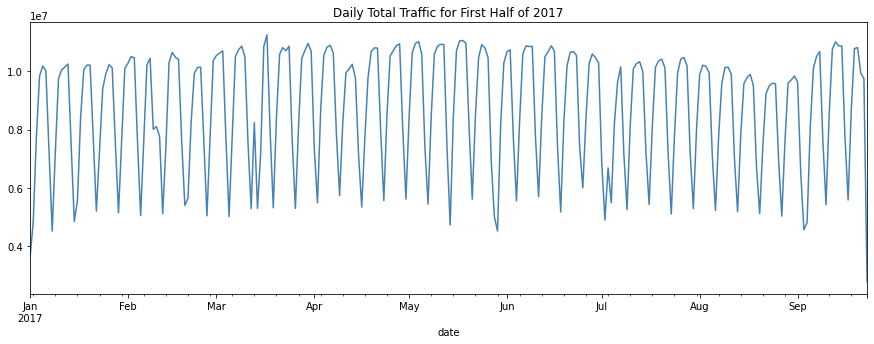

In [94]:
# Calcula a evolução temporal da ocupação ao longo do ano

mta_h1busy.set_index('date')['busy'].plot(color = 'steelblue', figsize=(15,5))
plt.title('Daily Total Traffic for First Half of 2017') 
plt.show()

Há uma periodicidade clara. É razoável supor que o tráfego aumenta durante a semana e reduz nos finais de semana.

### 5.2 Trafégo por dia da semana - periodicidade

Nas estações de metrô de Nova York, os passageiros geralmente saem pelas catracas - por onde entram também os passageiros que chegam. De acordo com nossa observação, muitas pessoas utilizam as saídas de emergência nos horários de pico por conveniência, embora não haja emergências. Os alarmes não disparam de jeito nenhum. As entradas e saídas são registradas apenas nas catracas e não podem ser coletadas quando são utilizadas saídas de emergência, portanto, o total de entradas deve ser maior que o total de saídas, e suspeitamos que essa lacuna seja maior nos dias de semana e menor nos finais de semana.

A diferença entre o total de entradas e o total de saídas não é o número exato de saídas de emergência, mas pode ser usado como proxy. Representamos essa lacuna como a taxa de saída de emergência:

In [95]:
# Obtém o dia da semana

df_2017_h1['weekday'] = df_2017_h1['datetime'].dt.day_name()
df_2017_h1['weekday_number'] = df_2017_h1['datetime'].dt.dayofweek

df_2017_h1 = df_2017_h1[df_2017_h1['busy'] != 0]
df_2017_h1.head()

C:\Users\mille\AppData\Local\Temp\ipykernel_3460\3274736360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017_h1['weekday'] = df_2017_h1['datetime'].dt.day_name()
C:\Users\mille\AppData\Local\Temp\ipykernel_3460\3274736360.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017_h1['weekday_number'] = df_2017_h1['datetime'].dt.dayofweek


,turnstile,station,datetime,entries_diff,exits_diff,busy,date,weekday,weekday_number
1,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 04:00:00,220.0,29.0,249.0,2017-01-01,Sunday,6
2,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 08:00:00,80.0,13.0,93.0,2017-01-01,Sunday,6
3,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 12:00:00,12.0,9.0,21.0,2017-01-01,Sunday,6
4,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 16:00:00,46.0,42.0,88.0,2017-01-01,Sunday,6
5,A002-R051-02-00-00-59 ST,59 ST,2017-01-01 20:00:00,204.0,44.0,248.0,2017-01-01,Sunday,6


In [96]:
# Calcula o total de ocupação e saidas e entradas. Depois calcula a coluna que contém as saídas de emergência  

cols = ['entries_diff', 'exits_diff', 'busy', 'weekday', 'weekday_number']
weekday_ave = df_2017_h1[cols].groupby(['weekday','weekday_number']).sum().reset_index().sort_values(by = 'weekday_number')
weekday_ave['emgergency'] = (weekday_ave['entries_diff'] - weekday_ave['exits_diff'])/weekday_ave['busy']
weekday_ave = weekday_ave.set_index('weekday_number')
weekday_ave

,weekday,entries_diff,exits_diff,busy,emgergency
weekday_number,,,,,
0,Monday,164003452.0,125605122.0,289608574.0,0.132587
1,Tuesday,208668565.0,158702027.0,367370592.0,0.136011
2,Wednesday,222059108.0,168583564.0,390642672.0,0.136891
3,Thursday,224849518.0,170865090.0,395714608.0,0.136423
4,Friday,222966749.0,169146276.0,392113025.0,0.137258
5,Saturday,155245642.0,122616018.0,277861660.0,0.117431
6,Sunday,109404584.0,88689556.0,198094140.0,0.104572


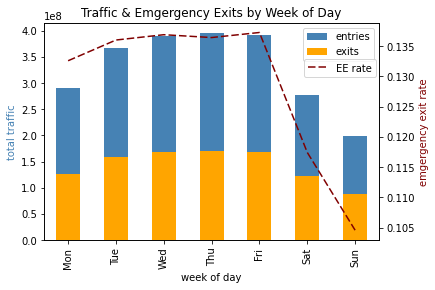

In [97]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

p1 = weekday_ave['busy'].plot(kind='bar', color='steelblue', ax=ax1, label = 'entries')
p1.legend(loc = 1)
p2 = weekday_ave['exits_diff'].plot(kind='bar', color='orange', ax=ax1, label = 'exits')
p2.legend(loc = 1)
p3 = weekday_ave['emgergency'].plot(kind='line', dashes = [5, 2], color='maroon', ax=ax2, label = 'EE rate')
p3.legend(loc = (0.775, 0.75)) 

plt.xticks((0,1,2,3,4,5,6),('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
ax1.set_xlabel('week of day')
ax1.set_ylabel('total traffic', color='steelblue')

ax2.set_ylabel('emgergency exit rate', color='maroon')
ax2.grid(False)
#ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
plt.title('Traffic & Emgergency Exits by Week of Day', size = 12) 
plt.show()

Como inferido, o tráfego nos dias de semana é geralmente muito mais intenso do que nos finais de semana, a taxa de saída de emergência segue a mesma tendência, o que confirmou nossa expectativa.

## 6. Forecast

Vamos fazer uma previsão diária do número de pessoas que usam o metrô. Entendemos que a simples entrada de uma pessoa pela catraca já caracteriza o uso do metrô. Por isso, faremos essa previsão tomando como base do número de pessoas que entram pela catraca.

In [98]:
df_2017_h1['date'] = df_2017_h1['datetime'].dt.date

mta_entries = df_2017_h1[['date', 'entries_diff']].groupby(['date']).sum().reset_index()
mta_entries['date'] = pd.to_datetime(mta_entries['date'])
mta_entries.set_index('date',inplace=True)
mta_entries.head()

,entries_diff
date,
2017-01-01,1987078.0
2017-01-02,2680717.0
2017-01-03,4407791.0
2017-01-04,5612709.0
2017-01-05,5815738.0


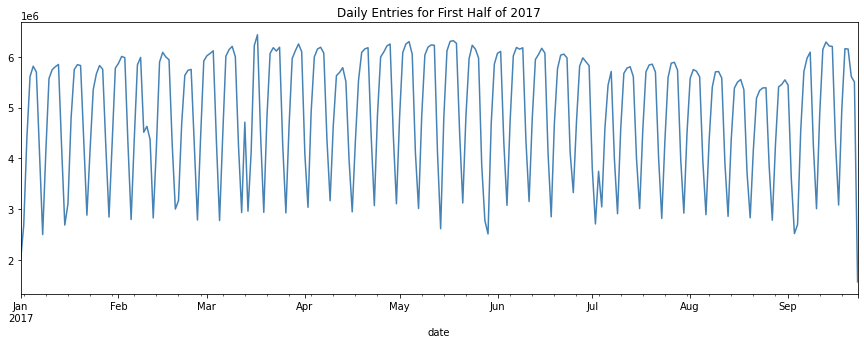

In [99]:
# Calcula a evolução temporal da ocupação ao longo do ano

mta_entries['entries_diff'].plot(color = 'steelblue', figsize=(15,5))
plt.title('Daily Entries for First Half of 2017') 
plt.show()

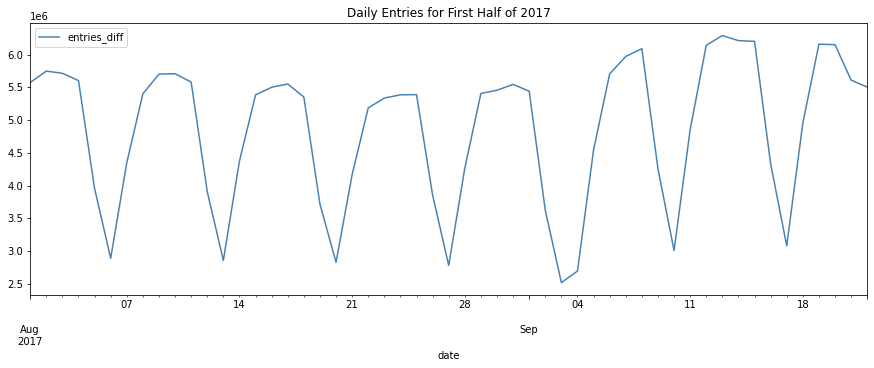

In [100]:
# Seleciona um período mais curto

mta_entries_ = mta_entries[['entries_diff']].loc['2017-08-01': '2017-09-22']
mta_entries_.plot(color = 'steelblue', figsize=(15,5))
plt.title('Daily Entries for First Half of 2017') 
plt.show()

Vamos verificar se o conjunto de dados fornecido é estacionário ou não, para isso usamos o adfuller.

In [101]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    #
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(mta_entries['entries_diff'])

ADF Test Statistic : -3.522573166901563
p-value : 0.0074259431148593095
#Lags Used : 14
Number of Observations : 251
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


C:\Users\mille\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mille\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


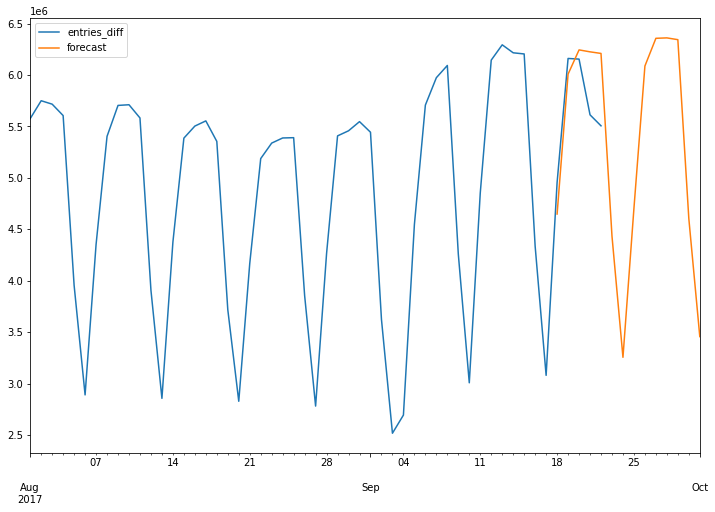

In [102]:
# A fim de fazer a previsão, usamos o método Sarimax

model = sm.tsa.statespace.SARIMAX(mta_entries_['entries_diff'],order=(1, 1, 1),seasonal_order=(1,1,1,7))
results = model.fit()

future_dates=[mta_entries_.index[-1]+ DateOffset(days=x) for x in range(0,10)]
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=mta_entries_.columns)

future_df = pd.concat([mta_entries_, future_datest_df])

future_df['forecast'] = results.predict(start = 48, end = 120, dynamic= True)
future_df[['entries_diff', 'forecast']].plot(figsize=(12, 8))
plt.show()

## 7. Média e quartis do tráfego diário por mês

In [103]:
# Cálculo da média mensal do total de tráfego para a estação 34 ST-PENN STA.

mta_penn = df_2017_h1[df_2017_h1['station'] == '34 ST-PENN STA'].groupby(by = 'date').agg({'busy' : sum}).reset_index()
mta_penn['date'] = pd.to_datetime(mta_penn['date'])
mta_penn['month'] = mta_penn['date'].dt.month
penn_month = mta_penn[['month', 'busy']].groupby('month')
penn_mean = penn_month.mean()

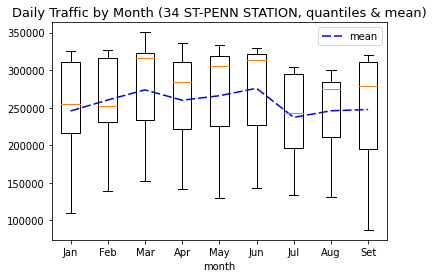

In [104]:
# Evolução da média por mês e sua comparação com a variabilidade dos dados

mta_penn['month']=mta_penn['month'].apply(str)
p1 = penn_mean.plot(kind='line', color = 'blue', dashes = (6, 2)) 
p1.legend(['mean'])
plt.boxplot([mta_penn[mta_penn['month'] == '1']['busy'].values,mta_penn[mta_penn['month'] == '2']['busy'].values,
             mta_penn[mta_penn['month'] == '3']['busy'].values,mta_penn[mta_penn['month'] == '4']['busy'].values,
             mta_penn[mta_penn['month'] == '5']['busy'].values,mta_penn[mta_penn['month'] == '6']['busy'].values,
             mta_penn[mta_penn['month'] == '7']['busy'].values,mta_penn[mta_penn['month'] == '8']['busy'].values,
             mta_penn[mta_penn['month'] == '9']['busy'].values])
plt.xticks((1,2,3,4,5,6,7,8,9),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Set'))
plt.title('Daily Traffic by Month (34 ST-PENN STATION, quantiles & mean)', size = 13)
plt.show()

Enquanto o tráfego médio varia pouco ao longo dos meses a mediana flutua consideravelmente e muito maior de janeiro a setembro.